In [1]:
import pandas as pd
import json

d4j_perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

bears_perturbed_bugs = {"Bears-140","Bears-1","Bears-194","Bears-196","Bears-213",
                        "Bears-205","Bears-232","Bears-204","Bears-98","Bears-251",
                        "Bears-153","Bears-180","Bears-165","Bears-207","Bears-198",
                        "Bears-186","Bears-210","Bears-190","Bears-241","Bears-166",
                        "Bears-199","Bears-200","Bears-234","Bears-240","Bears-250",
                        "Bears-223","Bears-144","Bears-212","Bears-214","Bears-169",
                        "Bears-242","Bears-246","Bears-156","Bears-84","Bears-238",
                        "Bears-157","Bears-202","Bears-231","Bears-243","Bears-247",
                        "Bears-233","Bears-239","Bears-220","Bears-245","Bears-158",
                        "Bears-209","Bears-188","Bears-229","Bears-193","Bears-230",
                        "Bears-211","Bears-221","Bears-222","Bears-228","Bears-248",
                        "Bears-201","Bears-224","Bears-176","Bears-27","Bears-227",
                        "Bears-249","Bears-142","Bears-225","Bears-159","Bears-170",
                        "Bears-197","Bears-226","Bears-184","Bears-177","Bears-149",
                        "Bears-206","Bears-155"}

def read_eval_d4j(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(d4j_perturbed_bugs)]
    return df

def read_eval_bears(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(bears_perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df, k):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        for fix in row[0]:
            if int(fix["k"]) > k:
                continue
            all_count += 1
            if fix["compile_exec"] and fix["compile_pass"]:
                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_fixed(df, k):
    count = 0
    for index, row in df.iterrows():
        all_fixed = []
        for hunk in row.hunks:
            fixed = False
            for i, fix in enumerate(row.hunks[hunk]["patches"]):
                if int(fix["k"]) > k:
                    continue
                if fix["identical"]:
                    fixed = True
                    break
            all_fixed += [fixed]
        if True in all_fixed and not False in all_fixed:
            count += 1
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_fixed(df):
    result = []
    for index, row in df.iterrows():
        all_fixed = []
        for hunk in row.hunks:
            fixed = False
            for i, fix in enumerate(row.hunks[hunk]["patches"]):
                if fix["identical"]:
                    fixed = True
                    break
            all_fixed += [fixed]
        if True in all_fixed and not False in all_fixed:
            result += [index]
    return result

In [5]:
def get_table_entry(beam_width, ex, round_, 
                    cb_1, cb_5, cb_10, cb_25, cb_50, cb_100, 
                    tb_1, tb_5, tb_10, tb_25, tb_50, tb_100,
                    cd_1, cd_5, cd_10, cd_25, cd_50, cd_100,
                    td_1, td_5, td_10, td_25, td_50, td_100):
    return {"Hyper Parameters": {
                "" :   { "Beam Width" : beam_width }
            },
            "Training": {
                "Experiment" : { "" : ex },
                "Round" : { "" : round_ }
            },
            "Testing":{
                "Bears Compile" :
                { "Top-1" : cb_1 , "Top-5" : cb_5 , "Top-10" : cb_10 , "Top-25" : cb_25, "Top-50" : cb_50 , "Top-100" : cb_100 },
                "Bears Test Pass" :
                { "Top-1" : tb_1 , "Top-5" : tb_5 , "Top-10" : tb_10 , "Top-25" : tb_25, "Top-50" : tb_50 , "Top-100" : tb_100 },
                "Defects4J Compile" :
                { "Top-1" : cd_1 , "Top-5" : cd_5 , "Top-10" : cd_10 , "Top-25" : cd_25, "Top-50" : cd_50 , "Top-100" : cd_100 },
                "Defects4J Tests Pass" :
                { "Top-1" : td_1 , "Top-5" : td_5 , "Top-10" : td_10 , "Top-25" : td_25, "Top-50" : td_50 , "Top-100" : td_100 },
            }
       }

In [7]:
from os.path import exists

entries = []
top_k = [1, 5, 10, 25, 50, 100]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_bears_bw_100.json" % (ex, ro_path)
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_bears_bw_100.json" % (ex, ro_path)
        d4j_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_defects4j_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_defects4j_bw_100.json" % (ex, ro_path)
        
        read_eval = read_eval_d4j if "defects4j" in ex else read_eval_bears
        cb = [get_number_compile(read_eval(bears_path_comp), k) for k in top_k] if exists(bears_path_comp) else ["N/A" for _ in top_k]
        tb = [get_number_fixed(read_eval(bears_path), k) for k in top_k] if exists(bears_path) else ["N/A" for _ in top_k]
        cd = [get_number_compile(read_eval(d4j_path_comp), k) for k in top_k] if exists(d4j_path_comp) else ["N/A" for _ in top_k]
        td = [get_number_fixed(read_eval(d4j_path), k) for k in top_k] if exists(d4j_path) else ["N/A" for _ in top_k]
        
        entries += [get_table_entry(100, ex, ro, *cb, *tb, *cd, *td)]

In [8]:
pd.set_option('display.max_columns', 27)
pd.set_option('display.max_rows', 16)
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table

Hyper Parameters           Training                            Testing  \
                            Experiment            Round     Bears Compile   
         Beam Width                                                 Top-1   
0               100   defects4j_buglab           round0  12 / 73 (16.44%)   
1               100   defects4j_buglab  round1-nocritic  14 / 74 (18.92%)   
2               100   defects4j_buglab  round1-compiler  44 / 74 (59.46%)   
3               100   defects4j_buglab     round1-tests  26 / 74 (35.14%)   
4               100  defects4j_selfapr           round0    6 / 74 (8.11%)   
5               100  defects4j_selfapr  round1-nocritic   8 / 74 (10.81%)   
6               100  defects4j_selfapr  round1-compiler  14 / 74 (18.92%)   
7               100  defects4j_selfapr     round1-tests  12 / 74 (16.22%)   
8               100       bears_buglab           round0               N/A   
9               100       bears_buglab  round1-nocritic               N/A   
10              100       bears_buglab  round1-compiler               N/A   
11              100       bears_buglab     round1-tests               N/A   
12              100      bears_selfapr           round0               N/A   
13              100      bears_selfapr  round1-nocritic               N/A   
14              100      bears_selfapr  round1-compiler               N/A   
15              100      bears_selfapr     round1-tests               N/A   

                                                                 \
                                                                  
                 Top-5              Top-10               Top-25   
0     31 / 365 (8.49%)    45 / 730 (6.16%)    84 / 1825 (4.60%)   
1    59 / 370 (15.95%)   99 / 740 (13.38%)  203 / 1850 (10.97%)   
2   123 / 370 (33.24%)  214 / 740 (28.92%)  470 / 1850 (25.41%)   
3    98 / 370 (26.49%)  170 / 740 (22.97%)  392 / 1850 (21.19%)   
4     27 / 370 (7.30%)    46 / 740 (6.22%)    87 / 1850 (4.70%)   
5     29 / 370 (7.84%)    47 / 740 (6.35%)   108 / 1850 (5.84%)   
6    44 / 370 (11.89%)   75 / 740 (10.14%)   149 / 1850 (8.05%)   
7    38 / 370 (10.27%)    62 / 740 (8.38%)   113 / 1850 (6.11%)   
8                  N/A                 N/A                  N/A   
9                  N/A                 N/A                  N/A   
10                 N/A                 N/A                  N/A   
11                 N/A                 N/A                  N/A   
12                 N/A                 N/A                  N/A   
13                 N/A                 N/A                  N/A   
14                 N/A                 N/A                  N/A   
15                 N/A                 N/A                  N/A   

                                                                \
                                               Bears Test Pass   
                 Top-50               Top-100            Top-1   
0    135 / 3650 (3.70%)    306 / 7300 (4.19%)  0 / 250 (0.00%)   
1   371 / 3700 (10.03%)   743 / 7400 (10.04%)  0 / 250 (0.00%)   
2   872 / 3700 (23.57%)  1673 / 7400 (22.61%)  0 / 250 (0.00%)   
3   743 / 3700 (20.08%)  1471 / 7400 (19.88%)  0 / 250 (0.00%)   
4    118 / 3700 (3.19%)    199 / 7400 (2.69%)  0 / 250 (0.00%)   
5    163 / 3700 (4.41%)    264 / 7400 (3.57%)  0 / 250 (0.00%)   
6    230 / 3700 (6.22%)    427 / 7400 (5.77%)  0 / 250 (0.00%)   
7    179 / 3700 (4.84%)    324 / 7400 (4.38%)  0 / 250 (0.00%)   
8                   N/A                   N/A              N/A   
9                   N/A                   N/A              N/A   
10                  N/A                   N/A              N/A   
11                  N/A                   N/A              N/A   
12                  N/A                   N/A  0 / 178 (0.00%)   
13                  N/A                   N/A              N/A   
14                  N/A                   N/A              N/A   
15                  N/A                   N/A              N/A   

          

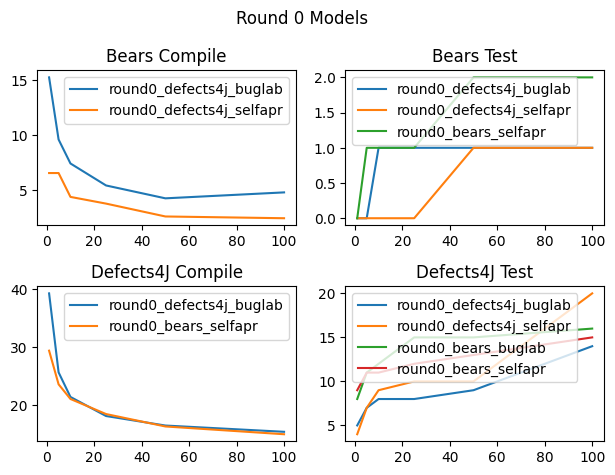

In [11]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0"]

figure, axis = plt.subplots(2, 2)
axis[0, 0].set_title("Bears Compile")
axis[0, 1].set_title("Bears Test")
axis[1, 0].set_title("Defects4J Compile")
axis[1, 1].set_title("Defects4J Test")

for ex in experiments:
    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_bears_bw_100.json" % (ex, ro_path)
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_bears_bw_100.json" % (ex, ro_path)
        d4j_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_defects4j_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_defects4j_bw_100.json" % (ex, ro_path)
        
        if exists(bears_path_comp):
            cb = [float(get_number_compile(read_eval(bears_path_comp), k).split("(")[1].split("%")[0]) for k in top_k]
            axis[0, 0].plot(top_k, cb, label=ro+"_"+ex)
        if exists(bears_path):
            tb = [int(get_number_fixed(read_eval(bears_path), k).split("/")[0]) for k in top_k]
            axis[0, 1].plot(top_k, tb, label=ro+"_"+ex)
        if exists(d4j_path_comp):
            cb = [float(get_number_compile(read_eval(d4j_path_comp), k).split("(")[1].split("%")[0]) for k in top_k]
            axis[1, 0].plot(top_k, cb, label=ro+"_"+ex)
        if exists(d4j_path):
            tb = [int(get_number_fixed(read_eval(d4j_path), k).split("/")[0]) for k in top_k]
            axis[1, 1].plot(top_k, tb, label=ro+"_"+ex)
            
axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
plt.suptitle("Round 0 Models")
figure.tight_layout()
plt.show()

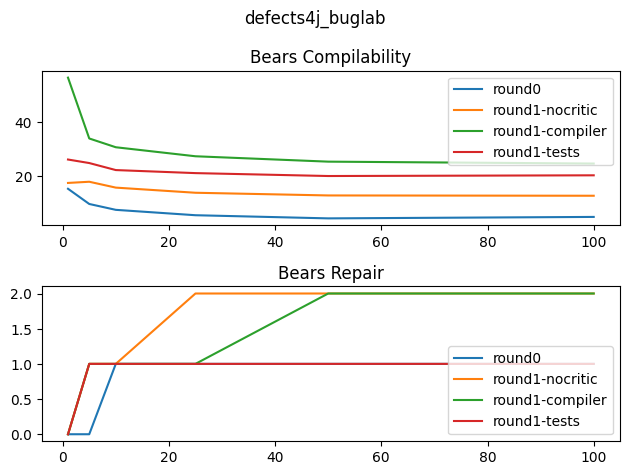

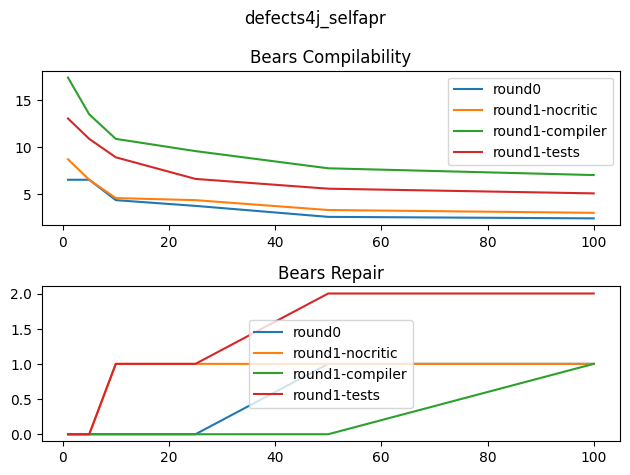

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


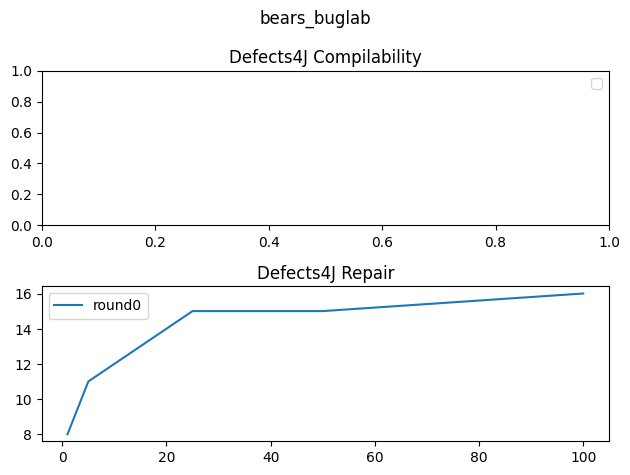

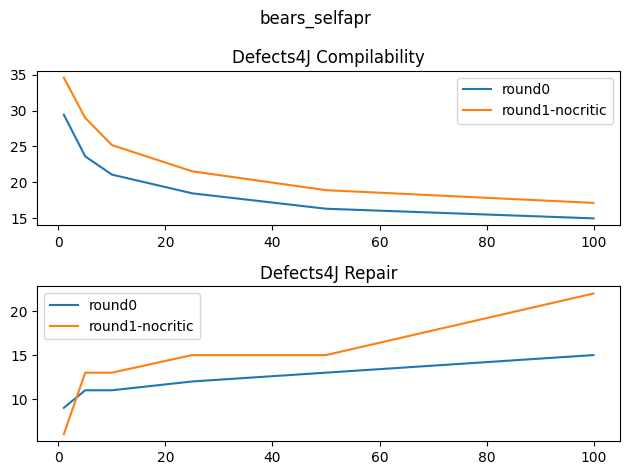

In [12]:
from os.path import exists
from matplotlib import pyplot as plt

entries = []
top_k = [1, 5, 10, 25, 50, 100]
#top_k = [i for i in range(1, 101)]
experiments = ["defects4j_buglab", "defects4j_selfapr", "bears_buglab", "bears_selfapr"]
rounds = ["round0", "round1-nocritic", "round1-compiler", "round1-tests"]

for ex in experiments:
    figure, axis = plt.subplots(2)
    axis[0].set_title("%s Compilability" % ("Defects4J" if "bears" in ex else "Bears"))
    axis[1].set_title("%s Repair" % ("Defects4J" if "bears" in ex else "Bears"))

    for ro in rounds:
        ro_path = ro if ro == "round0" else "%s/part2" % ro
        bears_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_bears_bw_100.json" % (ex, ro_path)
        bears_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_bears_bw_100.json" % (ex, ro_path)
        d4j_path_comp = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_compilability_defects4j_bw_100.json" % (ex, ro_path)
        d4j_path = "/mnt/data/andre/mscthesis/experiments/%s/%s/fixer/eval_defects4j_bw_100.json" % (ex, ro_path)
        
        if "defects4j" in ex:
            if exists(bears_path_comp):
                cb = [float(get_number_compile(read_eval(bears_path_comp), k).split("(")[1].split("%")[0]) for k in top_k]
                axis[0].plot(top_k, cb, label=ro)
            if exists(bears_path):
                tb = [int(get_number_fixed(read_eval(bears_path), k).split("/")[0]) for k in top_k]
                axis[1].plot(top_k, tb, label=ro)
        if "bears" in ex:
            if exists(d4j_path_comp):
                cb = [float(get_number_compile(read_eval(d4j_path_comp), k).split("(")[1].split("%")[0]) for k in top_k]
                axis[0].plot(top_k, cb, label=ro)
            if exists(d4j_path):
                tb = [int(get_number_fixed(read_eval(d4j_path), k).split("/")[0]) for k in top_k]
                axis[1].plot(top_k, tb, label=ro)
            
    axis[0].legend()
    axis[1].legend()
    plt.suptitle(ex)
    figure.tight_layout()
    plt.show()